# Population Segmentation Dataset


## 1. DATA COLLECTION WITH AWS S3
- Use AWS S3 bucket is a storage location to Pop Segmentation dataset

## 2. EXPLORATORY DATA ANALYSIS & DATA CLEANING
- Find missing values (replace them with mean/media/mode, KNN, or KMEANs) 

## 3. FEATURE ENGINEERING
- KMeans and DBSCAN uses euclidean distance
- We want to minimize the distance lnegth between two points in Euclidean space
- Since we're using KMeans and DBSCAN, it's required to scale the data
- Find different ways to scale the data (Gussian Distribution)

## 4. FEATURE SELECTION

In [75]:
import pandas as pd 
import numpy as np 
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pprint import pprint 
import plotly.express as px

# 1. DATA COLLECTION WITH AWS S3

In [76]:
# use boto3 client to get S3 bucket
s3_client = boto3.client('s3')
obj_list=s3_client.list_objects(Bucket='aws-ml-blog-sagemaker-census-segmentation')

# print objects in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
file_name=files[0]


data_object = s3_client.get_object(Bucket='aws-ml-blog-sagemaker-census-segmentation', Key=file_name)
data_body = data_object["Body"].read()
data_stream = io.BytesIO(data_body)

# create a pandas dataframe
df = pd.read_csv(data_stream, header=0, delimiter=",") 
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


# EXPLORATORY DATA ANALYSIS & DATA CLEANING

In [77]:
# provides a quantitative summary for each column (count, mean, std, min, max, etc)
df.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3220.000000,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.605280,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,16292.078954,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,1001.000000,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,19032.500000,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46105.500000,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


In [78]:
print(f'Number of rows of DataFrame {df.shape[0]}')
print(f'Number of columns of DataFrame {df.shape[1]}')

Number of rows of DataFrame 3220
Number of columns of DataFrame 37


In [79]:
# get datatype for each feature (string, float, int, bool, object, etc)
# State and County are object
pprint(df.columns.to_series().groupby(df.dtypes).groups)

{dtype('int64'): Index(['CensusId', 'TotalPop', 'Men', 'Women', 'Citizen', 'IncomePerCap',
       'IncomePerCapErr', 'Employed'],
      dtype='object'),
 dtype('float64'): Index(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomeErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object'),
 dtype('O'): Index(['State', 'County'], dtype='object')}


In [80]:
features = df.columns
numerical_feat = [features for features in df.columns if df[features].dtypes != 'O']
print(f'Number of Numerical Features: {len(numerical_feat)}')

categorical_feat = [features for features in df.columns if df[features].dtypes == 'O']
print(f'Number of Categorical Features: {len(categorical_feat)}')

Number of Numerical Features: 35
Number of Categorical Features: 2


# Find Missing Values

In [81]:
# find null values in DataFrame
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Found Null Values


In [82]:
# create a pandas dataframe with data_type, num_null_values, and percentage of null_values for each feature
df_details = pd.DataFrame(df.dtypes).T.rename(index={0:'datatype'})
df_details = df_details.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'num_null_values'}))
df_details = df_details.append(pd.DataFrame(df.isnull().sum()/len(df)*100).T.rename(index={0:'pct_null_values'}))
df_details

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
datatype,int64,object,object,int64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
num_null_values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pct_null_values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fill Null Values with Median since there's outliers

<AxesSubplot:>

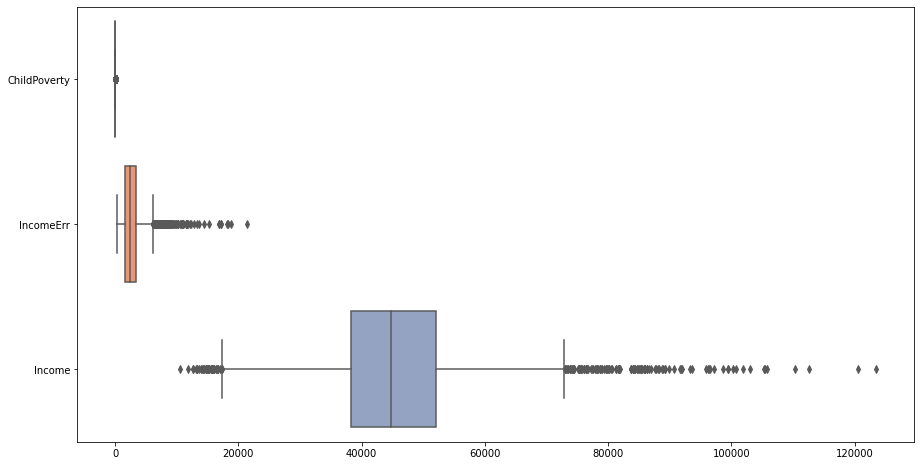

In [83]:
# Null values can be dropped, replaced by Median, Mean, or t-SNE
# Before filling Null values, analyz the data distribution for [ChildPoverty, IncomeErr, Income]
null_col = ['ChildPoverty', 'IncomeErr', 'Income']
plt.subplots(figsize=(15,8))
sns.boxplot(data=df[null_col], orient="h", palette="Set2")

In [84]:
# given the boxplot, there's alot of extreme values in IncomeErr and Income
# fill in null values with median, not mean (mean is sensitive to extreme values)
df = df.fillna(df.median())

In [85]:
# Verify if DataFrame still has null values 
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Data is Clean, No Null values found


In [86]:
df.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

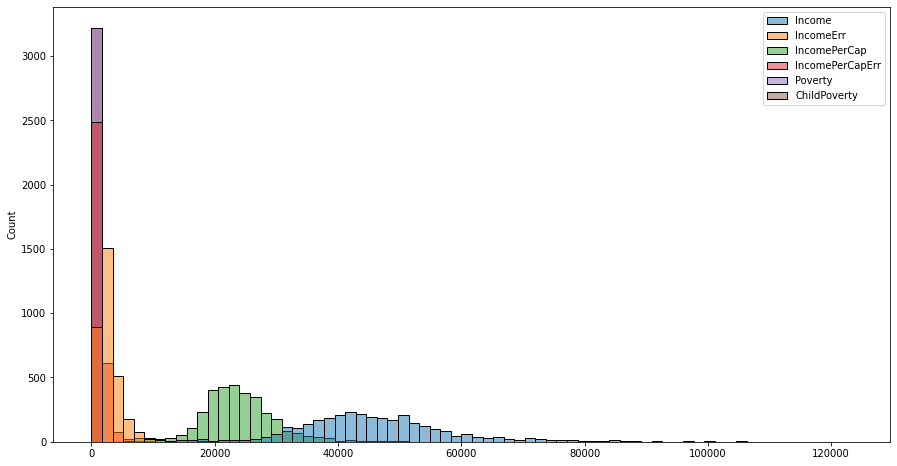

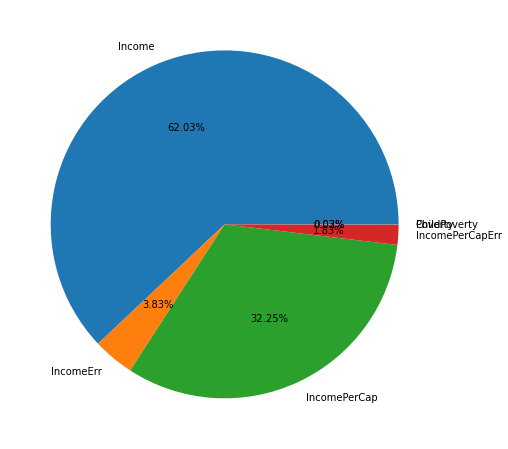

In [87]:
# income_list features historgram 
income_list = ['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty']
plt.subplots(figsize=(15,8))
sns.histplot(df[income_list].astype(float))


# pie chart of income sum
sizes = [df['Income'].sum(),
         df['IncomeErr'].sum(),
         df['IncomePerCap'].sum(),
         df['IncomePerCapErr'].sum(),
         df['Poverty'].sum(),
         df['ChildPoverty'].sum()
         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=income_list, autopct='%1.2f%%')
plt.show()


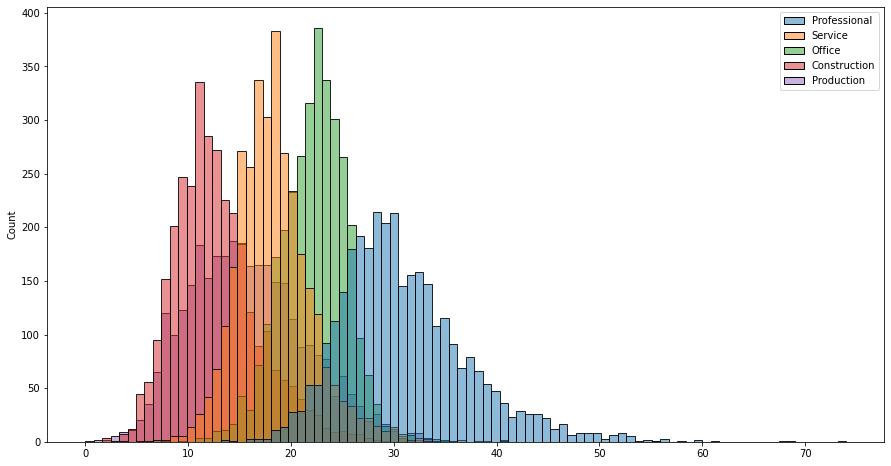

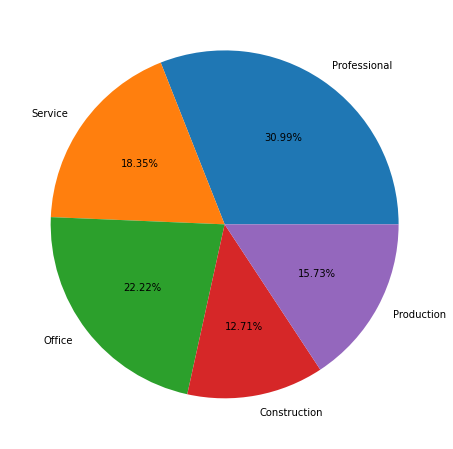

In [88]:
# occupation_list features historgram 
occupation_list = ['Professional', 'Service', 'Office', 'Construction', 'Production']
plt.subplots(figsize=(15,8))
sns.histplot(df[occupation_list].astype(float))

# pie chart of occupation_list
sizes = [df['Professional'].sum(),
         df['Service'].sum(),
         df['Office'].sum(),
         df['Construction'].sum(),
         df['Production'].sum(),         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=occupation_list, autopct='%1.2f%%', shadow=False)
plt.show()

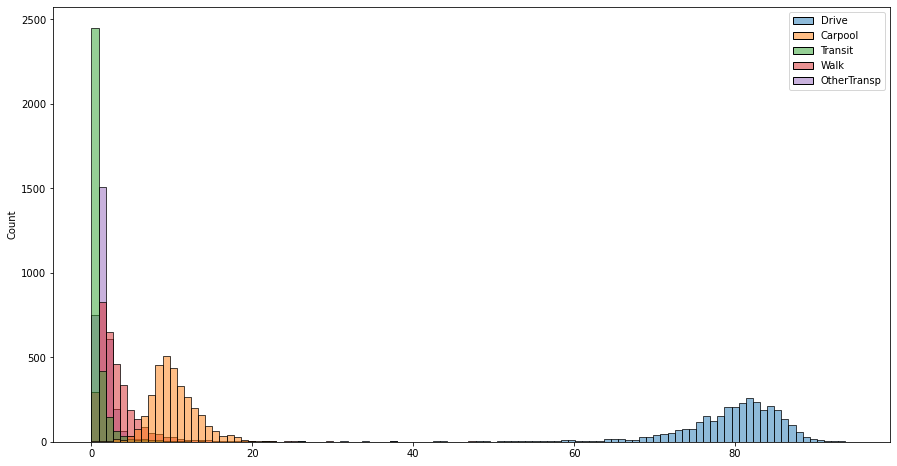

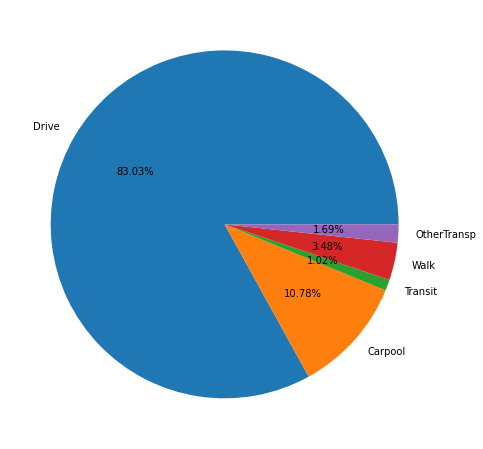

In [89]:
# transportation features historgram 
transportation_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
plt.subplots(figsize=(15,8))
sns.histplot(df[transportation_list].astype(float))


# pie chart of transportation_list
sizes = [df['Drive'].sum(),
         df['Carpool'].sum(),
         df['Transit'].sum(),
         df['Walk'].sum(),
         df['OtherTransp'].sum(),         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=transportation_list, autopct='%1.2f%%', shadow=False)
plt.show()

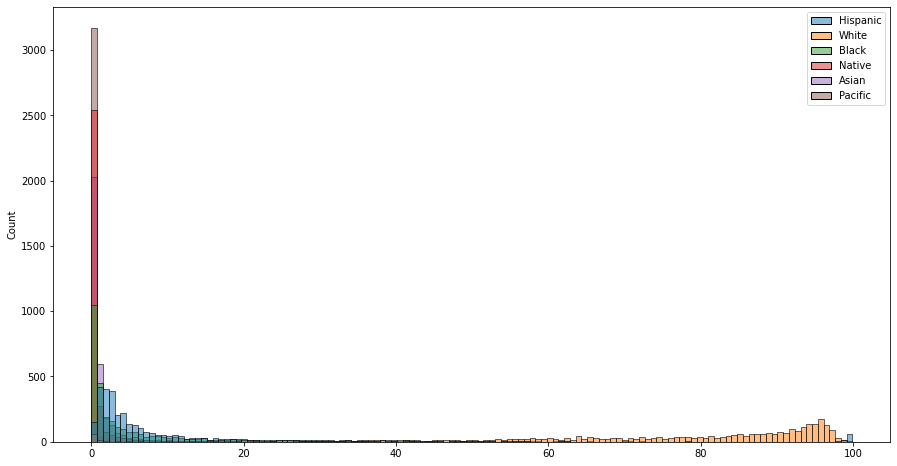

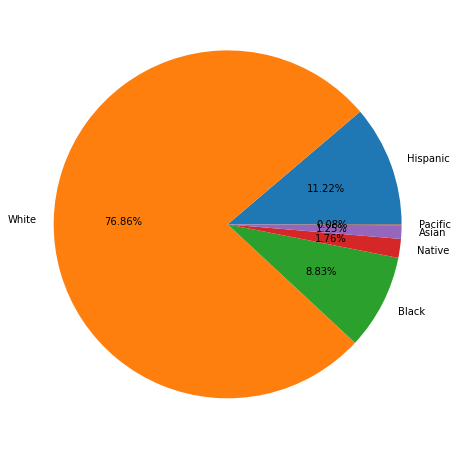

In [90]:
# race features historgram  
race_list = ['Hispanic', 'White', 'Black', 'Native', 'Asian','Pacific']
plt.subplots(figsize=(15,8))
sns.histplot(df[race_list].astype(float))

# pie chart of race_list
sizes = [df['Hispanic'].sum(),
         df['White'].sum(),
         df['Black'].sum(),
         df['Native'].sum(),
         df['Asian'].sum(),
         df['Pacific'].sum()
         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=race_list, autopct='%1.2f%%', shadow=False)
plt.show()

# VISUALIZE PEARSON CORRELATION 
## Helps identify any strong correlation between variables

<AxesSubplot:>

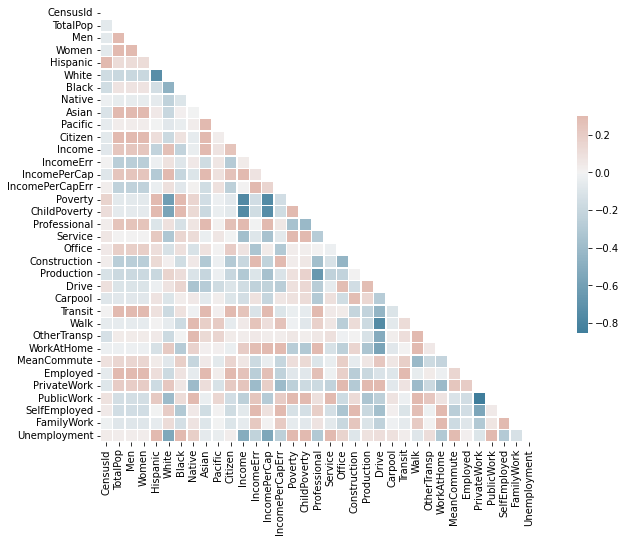

In [91]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks like [Poverty, ChildPoverty] are highly correlated with [Income, Income Cap]

# FEATURE ENGINEERING 

# Box-Plot
## Identifies outliers

<AxesSubplot:>

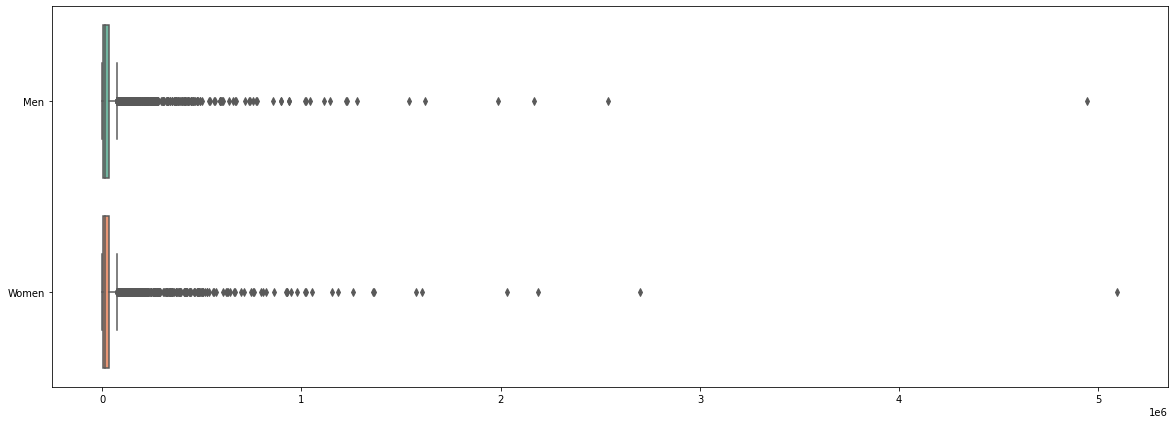

In [92]:
gender_list = ['Men', 'Women',]
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[gender_list], orient="h", palette="Set2")

# Box Plot for Race Features

<AxesSubplot:>

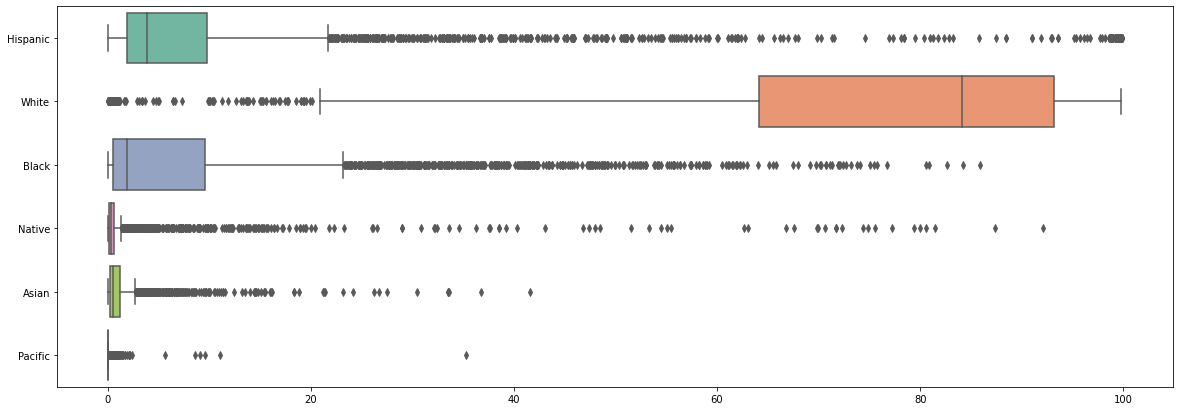

In [93]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[race_list], orient="h", palette="Set2")

# Box Plot for Occupations Features

<AxesSubplot:>

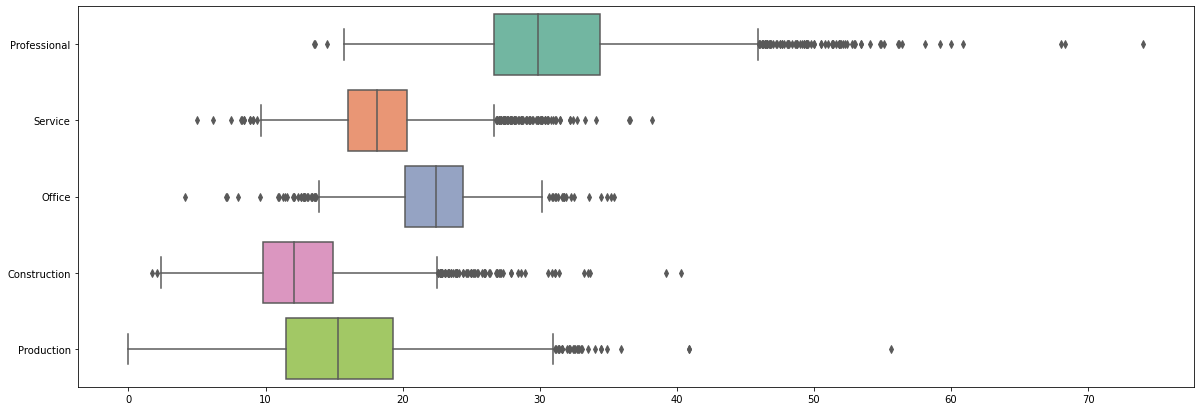

In [94]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[occupation_list], orient="h", palette="Set2")

# Box Plot for Transportation Features

<AxesSubplot:>

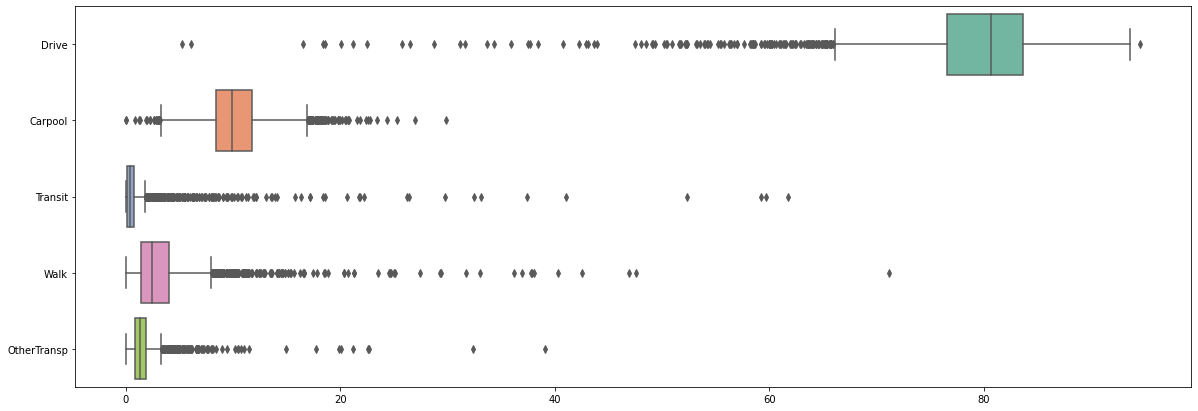

In [95]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[transportation_list], orient="h", palette="Set2")

# Box Plot for Income Features

<AxesSubplot:>

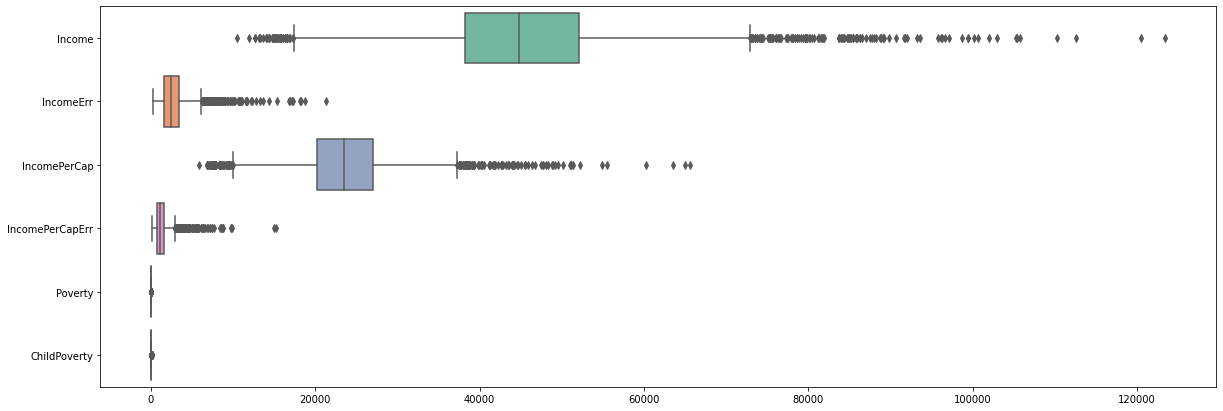

In [96]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[income_list], orient="h", palette="Set2")

# Implement Guassian Transformation for each cluster
- Logarithmic Transformation
- Reciprocal Transformation
- Square-Root Transformation
- Exponential Transformation
- Box-Cox Transformation

In [97]:
import scipy.stats as stats
import pylab
# plot two diagram (distribution histogram and boxplot)
def plot_data(df, feature):
	plt.figure(figsize=(10,6))
	# first row, 1st column
	plt.subplot(1, 2, 1)
	df[feature].hist()
	# first row, 2 column
	plt.subplot(1, 2, 2)
	stats.probplot(df[feature], dist='norm', plot=pylab)
	plt.show()

In [120]:
def transform_feature(df, feature):
    df[feature+'_log'] = np.log(df[feature])

for i in gender_list:
        transform_feature(df, i)

df
# df['feature_log'] = np.log(df['feature'])
# plot_data(df, feature_log)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Men_log,Women_log,Men___log,Women___log
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,23986,73.6,20.9,5.5,0.0,7.6,10.194103,10.256817,10.194103,10.256817
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,85953,81.5,12.3,5.8,0.4,7.5,11.464932,11.510994,11.464932,11.510994
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,8597,71.8,20.8,7.3,0.1,17.6,9.581697,9.428270,9.581697,9.428270
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,8294,76.8,16.1,6.7,0.4,8.3,9.398727,9.262079,9.398727,9.262079
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,22189,82.0,13.5,4.2,0.4,7.7,10.258080,10.281855,10.258080,10.281855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,...,13660,78.3,17.6,4.1,0.0,15.2,10.217532,10.291433,10.217532,10.291433
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,...,2860,44.5,41.6,13.6,0.3,12.2,8.430545,8.421783,8.430545,8.421783
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,...,6795,59.2,27.5,13.1,0.2,25.9,9.399803,9.441373,9.399803,9.441373
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,8083,65.1,27.6,7.3,0.0,24.3,9.778378,9.832582,9.778378,9.832582


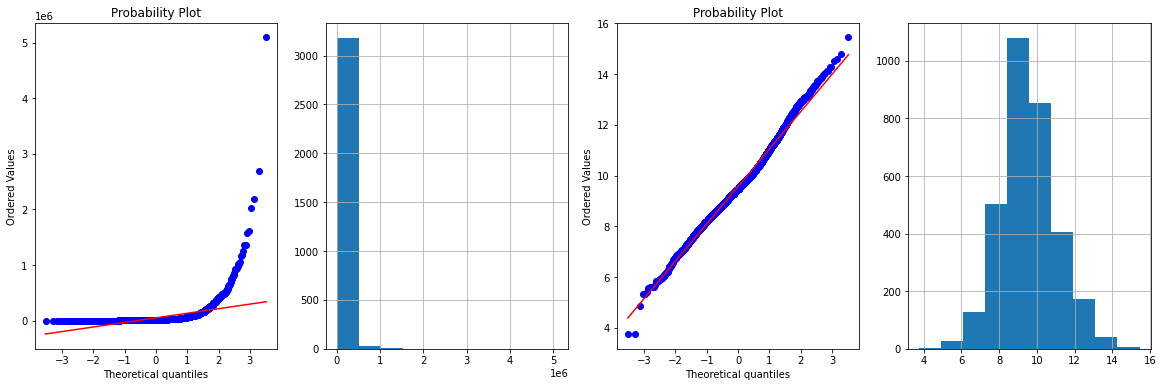

In [138]:
import scipy.stats as stats
import pylab
# plot two diagram (distribution histogram and boxplot)
def plot_data2(df, feature, feature_transform):
	plt.figure(figsize=(20,6))
	plt.subplot(1, 4, 1)
	stats.probplot(df[feature], dist='norm', plot=pylab)

	plt.subplot(1, 4, 2) 
	df[feature].hist()
     
	plt.subplot(1, 4, 3)
	stats.probplot(df[feature_transform], dist='norm', plot=pylab)

	plt.subplot(1, 4, 4)
	df[feature_transform].hist()
	plt.show()
 

plot_data2(df, 'Women', 'Women_log')

In [146]:
def transform_feature(df, feature):
    # df[feature+'_squared'] = df[feature] ** 0.5
    df[feature+'_boxcox'], parameters = stats.boxcox(df[feature] + 1)

for i in race_list:
        transform_feature(df, i)

# df['feature_boxcox'], parameters = stats.boxcox(df['feature'] + 1)
# plot_data(df, 'feature_boxcox')
# print(parameters)

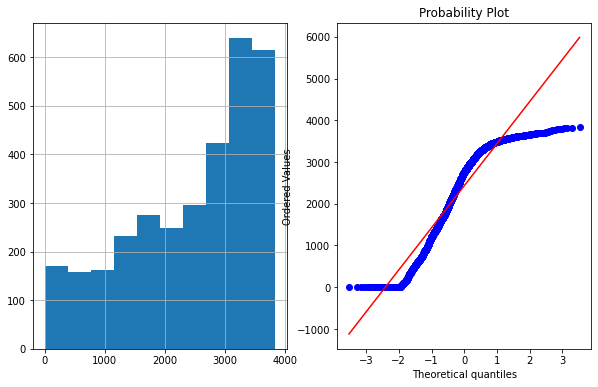

In [149]:
plot_data(df, 'White_boxcox')


In [148]:
race_list

['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

In [ ]:
col_names = ['Black', 'Native']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[col_names] = features


In [ ]:
# df['feature_boxcox'], parameters = stats.boxcox(df['Native']+1)
plot_data(df, 'Native')

In [ ]:
df['feature_boxcox'], parameters = stats.boxcox(df['Native']+1)
plot_data(df, 'feature_boxcox')

In [ ]:
df.columns

In [ ]:
df.Hispanic

In [ ]:
# Reduce 37 columns due to curse of dimensionality 
df1 = df.copy()

In [ ]:
df1.columns

In [ ]:
df1['population'] = df1.Men + df1.Women

df['un'] = df1['population'] - df.Citizen
df['un'] 

In [ ]:
pct_pop = df1.Employed/ df1.TotalPop
pct_pop.sort_values(ascending=False).head()

In [ ]:
# Combine 'State' and 'County' and index the column
df.index = df['State'] + '-' + df['County']


In [ ]:
# drop the 'CensusId', 'State', 'County' columns
df = df.drop(['CensusId', 'State', 'County'], axis=1)

In [ ]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks like [Poverty, ChildPoverty] are highly correlated with [Income, Income Cap]

In [ ]:
# plot a horizontal boxplot, helps identify [25, 50, 75%], mean, median, and outliers 
occupation_list = ['PrivateWork','PublicWork','SelfEmployed', 'Unemployment']

plt.subplots(figsize=(15,8))
sns.boxplot(data=df[occupation_list], orient="h", palette="Set2")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# transform and fit the data  in Standardize features by removing the mean and scaling to unit variance

# inittiate the StandardScaler
scaler = MinMaxScaler()

# fit and transform Standardize features as pandas DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df.astype(float)))
print(df_scaled.head())



In [ ]:
# rename the columns and define index 
df_scaled.columns = df.columns
df_scaled.index = df.index
print(df_scaled.columns)
print(df_scaled.index)


In [ ]:
# export the clean data into a csv file for ML model training 
df_scaled.to_csv('../inputs/population_seg.csv')

In [ ]:
# implement this in another rep py file 
# PCA for dimensionality reduction
# Feature engineering/transform
# Clustering transformed data with k-means
# Use Kmeans clustering model and evalute model 
